In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd

# Initialize the IRIS client
client = Client("IRIS")

# Define the range of catalog
minlat = 29
maxlat = 32
minlon = 77
maxlon = 81
starttime = UTCDateTime("2010-01-01")
endtime = UTCDateTime("2020-01-01")
minmag = 0
maxmag = 10

# Fetch events from the ISC catalog
cat = client.get_events(starttime=starttime, endtime=endtime,
                        minlatitude=minlat, maxlatitude=maxlat,
                        minlongitude=minlon, maxlongitude=maxlon,
                        minmagnitude=minmag, maxmagnitude=maxmag,
                        mindepth=0, maxdepth=100,
                        catalog="ISC")

# Prepare a list to store event details
event_data = []

# Loop through the events and extract relevant information
for event in cat:
    origin = event.preferred_origin() or event.origins[0]
    magnitude = event.preferred_magnitude() or event.magnitudes[0]

    # Extract latitude, longitude, magnitude, depth, and origin time
    lat = origin.latitude
    lon = origin.longitude
    mag = magnitude.mag
    depth = origin.depth / 1000 if origin.depth is not None else None  # Convert depth to kilometers
    origin_time = origin.time  # UTCDateTime

    # Append the event data (origin_time, lat, lon, mag, depth) to the list
    event_data.append([origin_time, lat, lon, mag, depth])

# Convert the list to a Pandas DataFrame
df = pd.DataFrame(event_data, columns=["Origin Time", "Latitude", "Longitude", "Magnitude", "Depth"])

# Save the DataFrame to a CSV file
df.to_csv("./seismic_events.csv", index=False)

# Print the DataFrame
print(df)

                     Origin Time  Latitude  Longitude  Magnitude  Depth
0    2015-08-25T08:41:04.590000Z   30.9470    77.6943        3.6   28.0
1    2015-08-07T15:46:38.690000Z   30.4116    80.4189        3.7   11.0
2    2015-08-06T21:43:41.100000Z   30.1560    79.3690        3.1   10.0
3    2015-08-05T19:15:56.500000Z   30.2923    80.4983        4.1   11.0
4    2015-07-26T16:59:06.000000Z   29.9745    80.6769        3.5   23.0
..                           ...       ...        ...        ...    ...
216  2010-01-26T06:51:16.470000Z   29.9884    80.3534        3.9   12.1
217  2010-01-11T19:42:44.600000Z   30.8860    77.8790        2.8   10.0
218  2010-01-11T05:15:13.490000Z   29.7659    80.4999        4.7   13.7
219  2010-01-05T15:04:25.750000Z   30.0907    80.1698        3.6    4.5
220  2010-01-01T02:42:50.200000Z   29.1530    80.6070        2.5   10.0

[221 rows x 5 columns]


makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


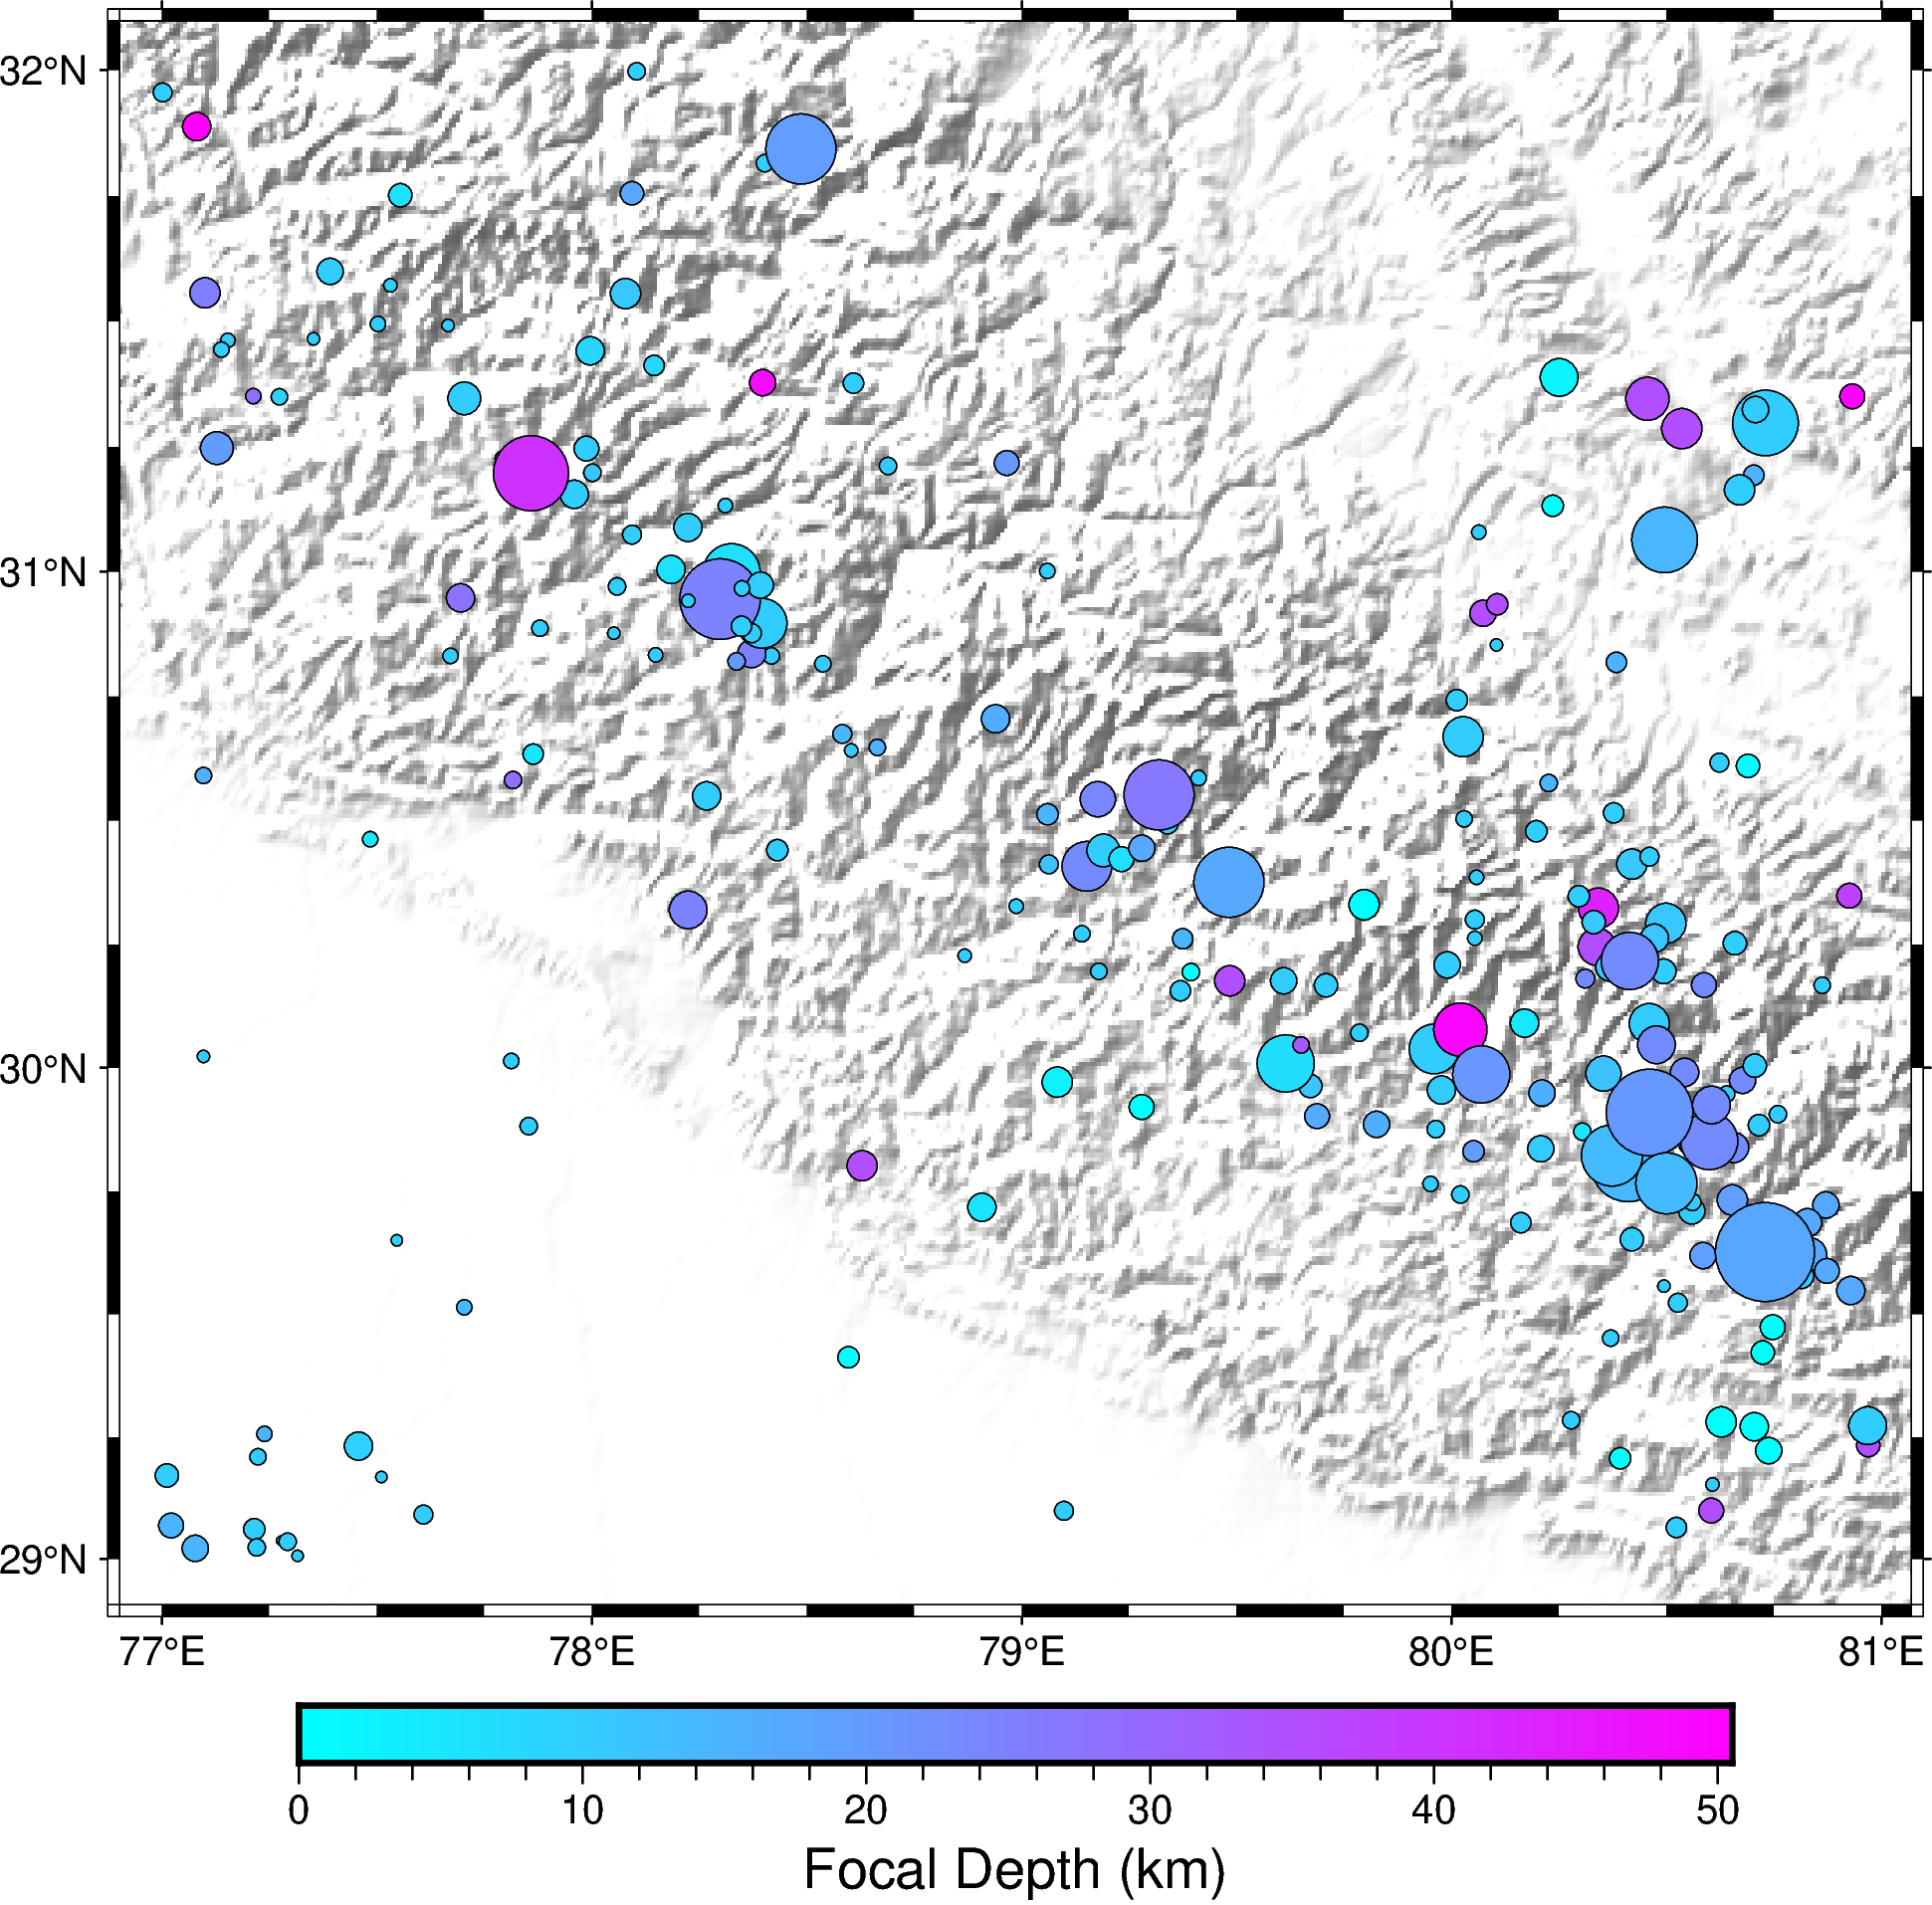

In [7]:
import pandas as pd
import pygmt

# Read the CSV file
df = pd.read_csv("/home/Rinku/Documents/seismic_events2.csv")
topo_data = '@earth_relief_30s'

# Determine the min and max latitude and longitude
min_lat = df["Latitude"].min() - 0.1  # Subtract 1 degree
max_lat = df["Latitude"].max() + 0.1  # Add 1 degree
min_lon = df["Longitude"].min() - 0.1  # Subtract 1 degree
max_lon = df["Longitude"].max() + 0.1  # Add 1 degree
region = [min_lon, max_lon, min_lat, max_lat]  # [west, east, south, north]

# Create a simple map
fig = pygmt.Figure()
fig.grdimage(grid=topo_data, cmap="white", region=region, projection='M6i', shading = True, frame = True)

# Create a coastline map with calculated region

pygmt.makecpt(cmap="cool", series=[df.Depth.min(), df.Depth.max()], continuous=True)

# Plot the earthquake events
#fig.plot(x=df["Longitude"], y=df["Latitude"], style="c0.1c", color="red", pen="black", label="Earthquakes")
fig.plot(x=df.Longitude,y=df.Latitude,size=0.02*(2 **df.Magnitude),fill=df.Depth,cmap=True,style="cc",pen="black")
fig.colorbar(frame='af+lFocal Depth (km)')

# Add a title
#fig.text(position="TR", text="ISC Earthquake Events (2010-2020)", font="12p,Helvetica-Bold,black", offset="0.2c")

# Show the legend
#fig.legend(position="JTR+jTR", box=True)

# Show the map
fig.show()

# Save the figure to a file if needed
# fig.savefig("isc_events_map.png")


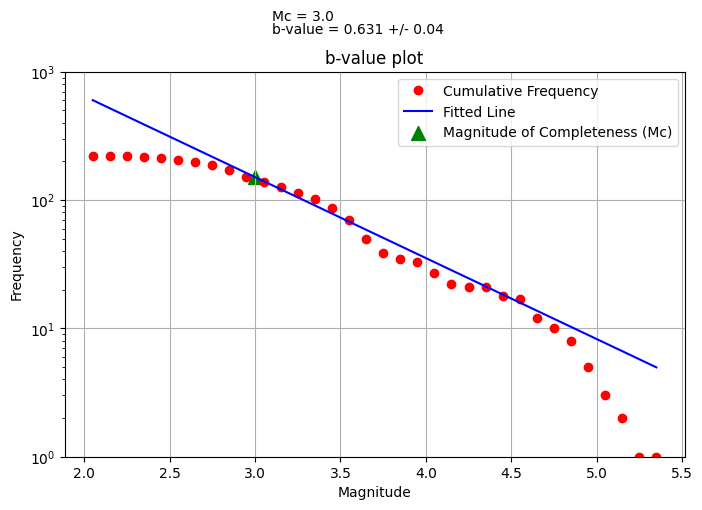

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Function to estimate b-value using maximum likelihood method (Aki, 1965)
def b_est(mag, mbin, mc):
    mag_above_mc = mag[np.where(mag > round(mc, 1) - mbin / 2)[0]]  # Magnitudes for events larger than cut-off magnitude mc
    n = mag_above_mc.shape[0]  # Number of events larger than cut-off magnitude mc
    if n < 2:
        a = np.nan
        b = np.nan
        aki_unc = np.nan
        shibolt_unc = np.nan
    else:
        mbar = np.mean(mag_above_mc)  # Mean magnitude for events larger than cut-off magnitude mc
        b = math.log10(math.exp(1)) / (mbar - (mc - mbin / 2))  # b-value
        a = math.log10(n) + b * mc  # 'a-value'
        aki_unc = b / math.sqrt(n)  # Aki uncertainty estimate
        shibolt_unc = 2.3 * b**2 * math.sqrt(np.sum((mag_above_mc - mbar)**2) / (n * (n - 1)))  # Shi & Bolt uncertainty estimate

    return a, b, aki_unc, shibolt_unc  # Return b-value and estimates of uncertainty

# Load the data
df = pd.read_csv('./seismic_events.csv')

# Extract magnitudes
magnitudes = df['Magnitude'].values

# Define parameters for b-value estimation
cat_mc = 3.0  # Set this to a higher value based on your analysis
mbin = 0.1  # Magnitude bin size

# Calculate b-value
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag=magnitudes, mbin=mbin, mc=cat_mc)

# Calculate frequency for plotting
# Create magnitude bins for frequency count
bin_edges = np.arange(magnitudes.min(), magnitudes.max() + mbin, mbin)
cat_nbmag, _ = np.histogram(magnitudes, bins=bin_edges)  # Number of events in each bin
cat_cumnbmag = np.cumsum(cat_nbmag[::-1])[::-1]  # Cumulative frequency

# Midpoint of bins for plotting
cat_mi = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Calculate fitted line values for plotting
fitted_line_values = (10 ** (cat_a - (cat_b * cat_mi)))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(cat_mi, cat_cumnbmag, 'o', label='Cumulative Frequency', color='red')  # Red dots for cumulative frequency
plt.plot(cat_mi, fitted_line_values, label='Fitted Line', color='blue')  # Fitted line in blue

# Calculate frequency at Mc using the fitted line
frequency_at_mc = 10 ** (cat_a - (cat_b * cat_mc))

# Plot green triangle at Mc value
plt.scatter(cat_mc, frequency_at_mc, color='green', marker='^', s=100, label='Magnitude of Completeness (Mc)')  # Green triangle at Mc

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(df.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('b-value plot')

# Adjusted text positions
plt.text(x=cat_mc + 0.1, y=2.5e3, s="Mc = " + str(round(cat_mc, 1)))  # Closer position for Mc
plt.text(x=cat_mc + 0.1, y=2e3, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))  # Closer position for b-value

plt.legend()
plt.grid(True)
plt.show()
